# ***DATA SCIENCE FOR BRITISH AIRWAYS***



First of all, I imported the necessary libraries and packages which will be required to carry out data collection, cleaning and exploratory analysis

In [48]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
lemma = WordNetLemmatizer()
from wordcloud import WordCloud
from nltk import ngrams
from nltk.probability import FreqDist

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

import plotly.express as px

import datetime as dt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Next, I created empty lists in which the data of reviews, stars, dates and country will be collected.

In [49]:
reviews  = []

stars = []

date = []

country = []

Next, I wrote code to run loops for all request pages and give info about each of the categories

In [50]:
for i in range(1, 36):
    page = requests.get(f"https://www.airlinequality.com/airline-reviews/british-airways/page/{i}/?sortby=post_date%3ADesc&pagesize=100")
    
    soup = BeautifulSoup(page.content, "html5")
    
    for item in soup.find_all("div", class_="text_content"):
        reviews.append(item.text)
    
    for item in soup.find_all("div", class_ = "rating-10"):
        try:
            stars.append(item.span.text)
        except:
            print(f"Error on page {i}")
            stars.append("None")
            
    #date
    for item in soup.find_all("time"):
        date.append(item.text)
        
    #country
    for item in soup.find_all("h3"):
        country.append(item.span.next_sibling.text.strip(" ()"))

Error on page 30
Error on page 31
Error on page 32
Error on page 34
Error on page 34


Next, I checked the length of the total reviews extracted

In [51]:
len(reviews)

3500

In [52]:
len(country)

3500

Now, I checked if the length of reviews and country are same, so that a dataframe could be created

In [53]:
stars = stars[:3500]

Next, I created a Dataframe from all the collected lists of data

In [54]:
df = pd.DataFrame({"reviews":reviews,"stars": stars, "date":date, "country": country})

In [55]:
df.head()

,reviews,stars,date,country
0,Not Verified | They changed our Flights from ...,\n\t\t\t\t\t\t\t\t\t\t\t\t\t5,18th April 2023,United States
1,Not Verified | At Copenhagen the most chaotic...,2,18th April 2023,United States
2,✅ Trip Verified | Worst experience of my life...,5,17th April 2023,United States
3,✅ Trip Verified | Due to code sharing with Ca...,1,17th April 2023,Hong Kong
4,✅ Trip Verified | LHR check in was quick at t...,3,16th April 2023,United Kingdom


In [56]:
df.shape

(3500, 4)

Next, I imported all these data into a CSV file.

In [57]:
cwd = os.getcwd()
df.to_csv(cwd+ "/Reviews_BA.csv")

Now, I created a Dataframe from the CSV file

In [58]:
cwd = os.getcwd()

df = pd.read_csv(cwd+"/Reviews_BA.csv", index_col=0)

In [59]:
df.head()

,reviews,stars,date,country
0,Not Verified | They changed our Flights from ...,\n\t\t\t\t\t\t\t\t\t\t\t\t\t5,18th April 2023,United States
1,Not Verified | At Copenhagen the most chaotic...,2,18th April 2023,United States
2,✅ Trip Verified | Worst experience of my life...,5,17th April 2023,United States
3,✅ Trip Verified | Due to code sharing with Ca...,1,17th April 2023,Hong Kong
4,✅ Trip Verified | LHR check in was quick at t...,3,16th April 2023,United Kingdom


Additionally, I created a column which meantions whether the user is verified  or not

In [60]:
df['verified'] = df.reviews.str.contains("Trip Verified")

In [61]:
df['verified']

0       False
1       False
2        True
3        True
4        True
        ...  
3495    False
3496    False
3497    False
3498    False
3499    False
Name: verified, Length: 3500, dtype: bool

# ***Data Cleaning***

Next, I extracted the column of reviews into a separate dataframe and cleaned it for semantic analysis

In [62]:
reviews_data = df.reviews.str.strip("✅ Trip Verified |")

corpus =[]

for rev in reviews_data:
    rev = re.sub('[^a-zA-Z]',' ', rev)
    rev = rev.lower()
    rev = rev.split()
    rev = [lemma.lemmatize(word) for word in rev if word not in set(stopwords.words("english"))]
    rev = " ".join(rev)
    corpus.append(rev)

Adding corpus to the original Dataframe

In [63]:
df['corpus'] = corpus

In [64]:
df.head()

,reviews,stars,date,country,verified,corpus
0,Not Verified | They changed our Flights from ...,\n\t\t\t\t\t\t\t\t\t\t\t\t\t5,18th April 2023,United States,False,verified changed flight brussels london heathr...
1,Not Verified | At Copenhagen the most chaotic...,2,18th April 2023,United States,False,verified copenhagen chaotic ticket counter ass...
2,✅ Trip Verified | Worst experience of my life...,5,17th April 2023,United States,True,worst experience life trying deal customer ser...
3,✅ Trip Verified | Due to code sharing with Ca...,1,17th April 2023,Hong Kong,True,due code sharing cathay pacific downgraded ba ...
4,✅ Trip Verified | LHR check in was quick at t...,3,16th April 2023,United Kingdom,True,lhr check quick first wing quickly security fi...


In [65]:
df.dtypes

reviews     object
stars       object
date        object
country     object
verified      bool
corpus      object
dtype: object

Converting Date to Datetime format

In [66]:
df.date = pd.to_datetime(df.date)

In [67]:
df.date.head()

0   2023-04-18
1   2023-04-18
2   2023-04-17
3   2023-04-17
4   2023-04-16
Name: date, dtype: datetime64[ns]

Checking for unique values of stars

In [68]:
df.stars.unique()

array(['\n\t\t\t\t\t\t\t\t\t\t\t\t\t5', '2', '5', '1', '3', '4', '9', '7',
       '10', '8', '6', 'None'], dtype=object)

Removing the \t and \n from the ratings

In [69]:
df.stars = df.stars.str.strip("\n\t\t\t\t\t\t\t\t\t\t\t\t\t")

In [70]:
df.stars.value_counts()

1       771
2       394
3       387
8       350
10      312
7       303
9       300
5       261
4       237
6       180
None      5
Name: stars, dtype: int64

There are 5 rows having values "None" in the ratings. So dropping all these 5 rows.

In [71]:
df.drop(df[df.stars == "None"].index, axis=0, inplace=True)
df.stars.unique()

array(['5', '2', '1', '3', '4', '9', '7', '10', '8', '6'], dtype=object)

Checking for Null Values

In [72]:
df.isnull().value_counts()

reviews  stars  date   country  verified  corpus
False    False  False  False    False     False     3493
                       True     False     False        2
dtype: int64

In [73]:
df.country.isnull().value_counts()

False    3493
True        2
Name: country, dtype: int64

There are two missing values for country. For this I just removed those two reviews (rows) from the dataframe.

In [74]:
df.drop(df[df.country.isnull() == True].index, axis=0, inplace=True)
df.shape

(3493, 6)

Now, resetting the index

In [75]:
df.reset_index(drop=True)

,reviews,stars,date,country,verified,corpus
0,Not Verified | They changed our Flights from ...,5,2023-04-18,United States,False,verified changed flight brussels london heathr...
1,Not Verified | At Copenhagen the most chaotic...,2,2023-04-18,United States,False,verified copenhagen chaotic ticket counter ass...
2,✅ Trip Verified | Worst experience of my life...,5,2023-04-17,United States,True,worst experience life trying deal customer ser...
3,✅ Trip Verified | Due to code sharing with Ca...,1,2023-04-17,Hong Kong,True,due code sharing cathay pacific downgraded ba ...
4,✅ Trip Verified | LHR check in was quick at t...,3,2023-04-16,United Kingdom,True,lhr check quick first wing quickly security fi...
...,...,...,...,...,...,...
3488,While different people have different experien...,5,2014-05-11,India,False,different people different experience wanted s...
3489,Once again a good flight from LHR to Warsaw in...,10,2014-05-11,United Kingdom,False,good flight lhr warsaw cabin crew efficient fr...
3490,LGW-MRU-LGW in business. Outbound flight good ...,6,2014-05-11,United Kingdom,False,lgw mru lgw business outbound flight good atte...
3491,LHR-FRA-LCY May 2014. LHR-FRA on a 767 row 18....,2,2014-05-11,United Kingdom,False,lhr fra lcy may lhr fra row checked via mobile...


Now the data is all cleaned and ready for data visualization and data analysis.

In [76]:
df.to_csv(cwd + "/Clean_Reviews_BA.csv")

# ***Exploratory Data Analysis on Cleaned Data of Reviews***

In [77]:
cwd = os.getcwd()
df = pd.read_csv(cwd+"/Clean_Reviews_BA.csv", index_col=0)

df = df.reset_index(drop=True)
df.head()

,reviews,stars,date,country,verified,corpus
0,Not Verified | They changed our Flights from ...,5,2023-04-18,United States,False,verified changed flight brussels london heathr...
1,Not Verified | At Copenhagen the most chaotic...,2,2023-04-18,United States,False,verified copenhagen chaotic ticket counter ass...
2,✅ Trip Verified | Worst experience of my life...,5,2023-04-17,United States,True,worst experience life trying deal customer ser...
3,✅ Trip Verified | Due to code sharing with Ca...,1,2023-04-17,Hong Kong,True,due code sharing cathay pacific downgraded ba ...
4,✅ Trip Verified | LHR check in was quick at t...,3,2023-04-16,United Kingdom,True,lhr check quick first wing quickly security fi...


Checking the average overall rating given for British Airways

In [78]:
df.stars.mean()

4.80561122244489

Checking total counts for each rating

Text(0.5, 0.98, 'Counts for each Rating types')

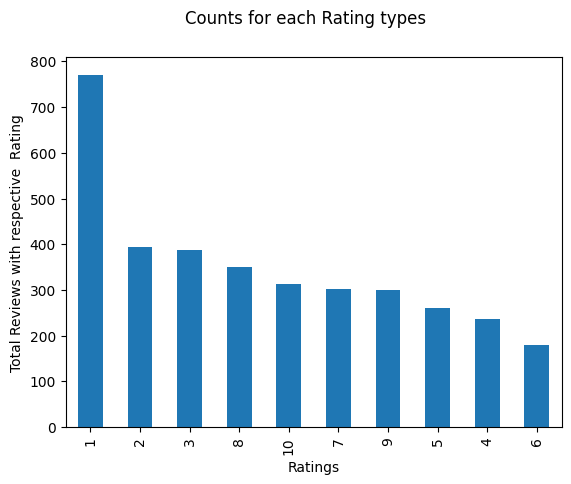

In [79]:
df.stars.value_counts().plot(kind="bar")
plt.xlabel("Ratings")
plt.ylabel("Total Reviews with respective  Rating")
plt.suptitle("Counts for each Rating types")

In [80]:
df_ratings = pd.DataFrame(df.stars.value_counts())
pct_values = (df_ratings.stars.values/ df_ratings.stars.values.sum() *100).tolist()
pct_values = [round(x,2) for x in pct_values]
df_ratings['pct_values'] = pct_values

Resetting index as we don't want confusion between the Index and the Rating values

In [81]:
df_ratings = df_ratings.reset_index()

Now, renaming the columns

In [82]:
df_ratings.rename(columns={'index':'Stars', 'stars':'total_counts'}, inplace=True)
df_ratings

,Stars,total_counts,pct_values
0,1,770,22.04
1,2,394,11.28
2,3,387,11.08
3,8,350,10.02
4,10,312,8.93
5,7,302,8.65
6,9,300,8.59
7,5,261,7.47
8,4,237,6.78
9,6,180,5.15


Text(0.5, 1.0, 'Counts for each Rating types')

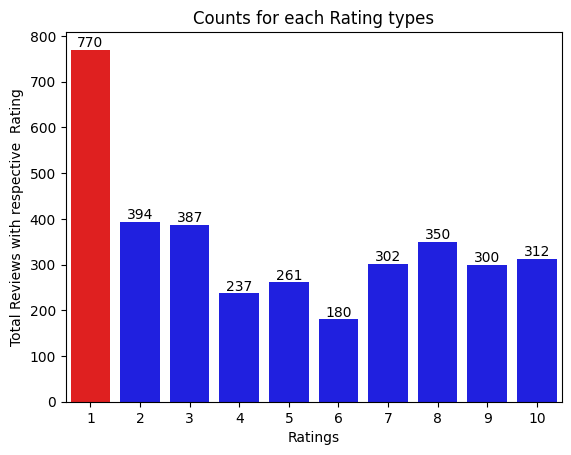

In [83]:
clrs = ['Red' if (x ==  max(df_ratings.total_counts)) else 'Blue' for x in df_ratings.total_counts ]
ax = sns.barplot(x=df_ratings.Stars, y=df_ratings.total_counts, data=df_ratings, errwidth=0,
                palette=clrs)


ax.bar_label(ax.containers[0])
    
ax.set_xlabel("Ratings")
ax.set_ylabel("Total Reviews with respective  Rating")
ax.set_title("Counts for each Rating types")

In [84]:
print(f"{len(df.country.unique())} unique countries")

69 unique countries


Countries with most Reviews

Text(0.5, 1.0, 'Maximum Reviews by Country')

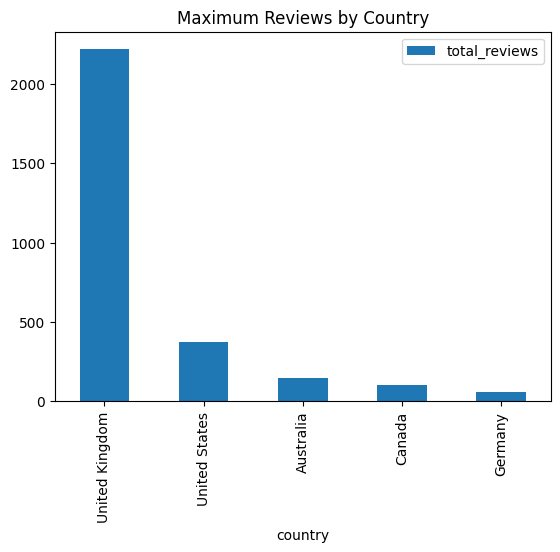

In [85]:
df_country_review = pd.DataFrame(df.country.value_counts().head()).reset_index()
df_country_review.rename(columns={'index':'country','country':'total_reviews'}, inplace=True)
df_country_review.plot(kind="bar", x='country')
plt.title("Maximum Reviews by Country")

Countries with Average highest Ratings

<ipython-input-86-5d43daeaba92>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Text(0.5, 1.0, 'Top 12 Countries with avg highest Rating for British Airways')

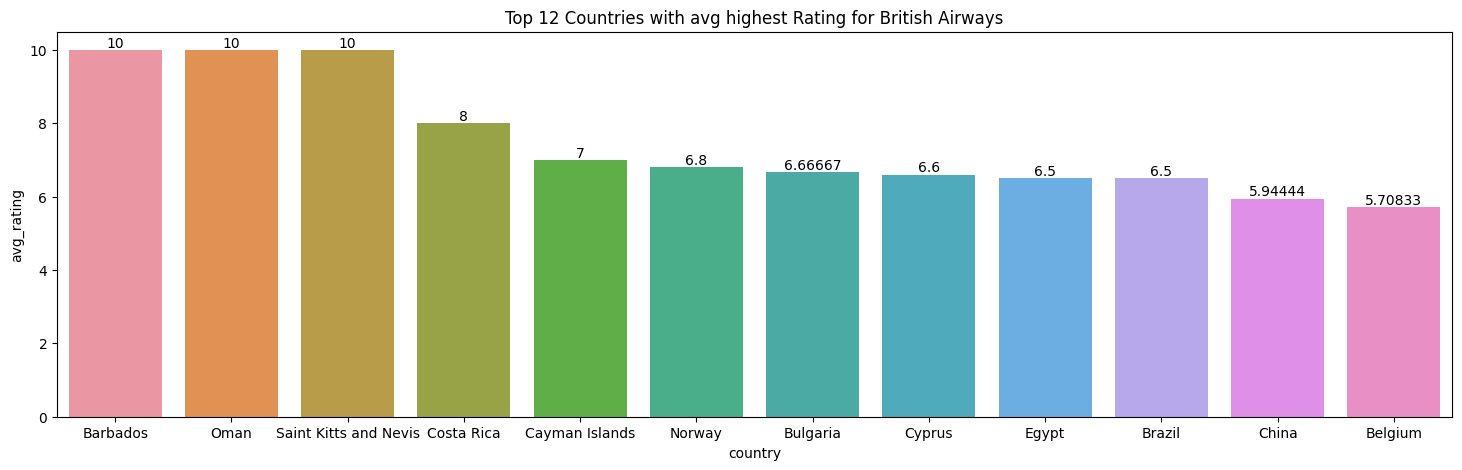

In [86]:
df_country_rating = pd.DataFrame(df.groupby('country').mean()['stars'].sort_values(ascending=False)).reset_index()
df_country_rating.rename(columns={'stars':'avg_rating'}, inplace=True)
fig, ax = plt.subplots(figsize=(18,5))
ax1 = sns.barplot(x='country', y='avg_rating', data=df_country_rating[:12])
ax.bar_label(ax.containers[0])
ax.set_title("Top 12 Countries with avg highest Rating for British Airways")

Converting Date to Datetime datatype

In [87]:
df.date = pd.to_datetime(df.date)

In [88]:
fig = px.line(df, x='date', y="stars")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

It can be seen that between April 2020 to August 2021 there has been a decline in reviews due to Covid Pandemic travel restrictions. Not much can be inferred at this point as the dates we have are the when the customers posted their reviews which does not take into account the actual flight date. Hence no particular significan trend is visible from the plot.

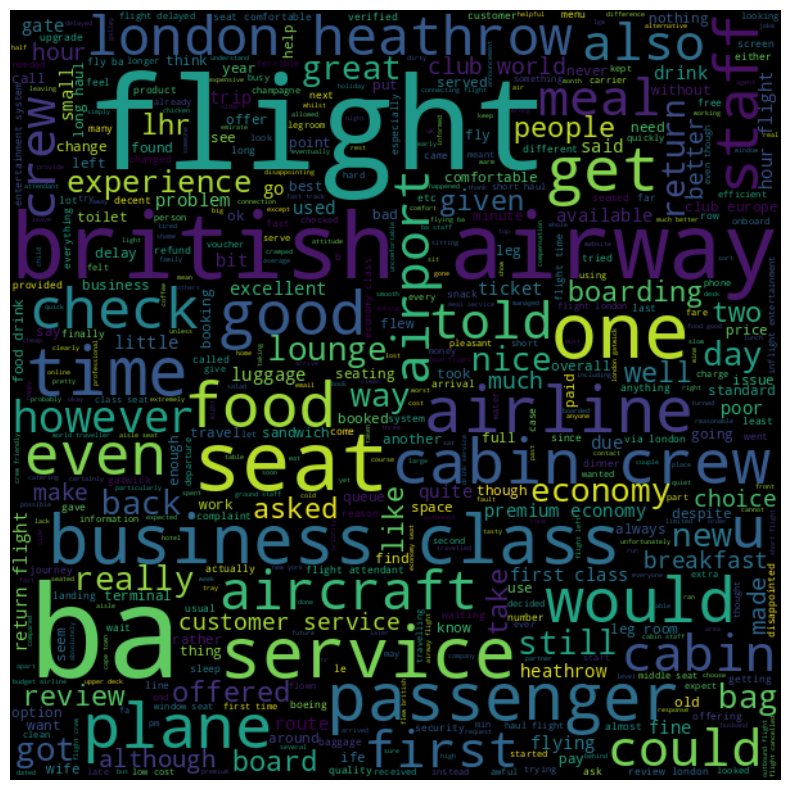

In [89]:
reviews = " ".join(df.corpus)
plt.figure(figsize=(20,10))

stopwords = set(stopwords.words('english'))

wordcloud = WordCloud(height=600,width=600,max_font_size=100, max_words=500, stopwords=stopwords).generate(reviews)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are many words that does not set the idea of whether the review is positive or negative. For example words like "passenger", "flight", etc. does not add conlcusive value hence we can include them in stopwords list.

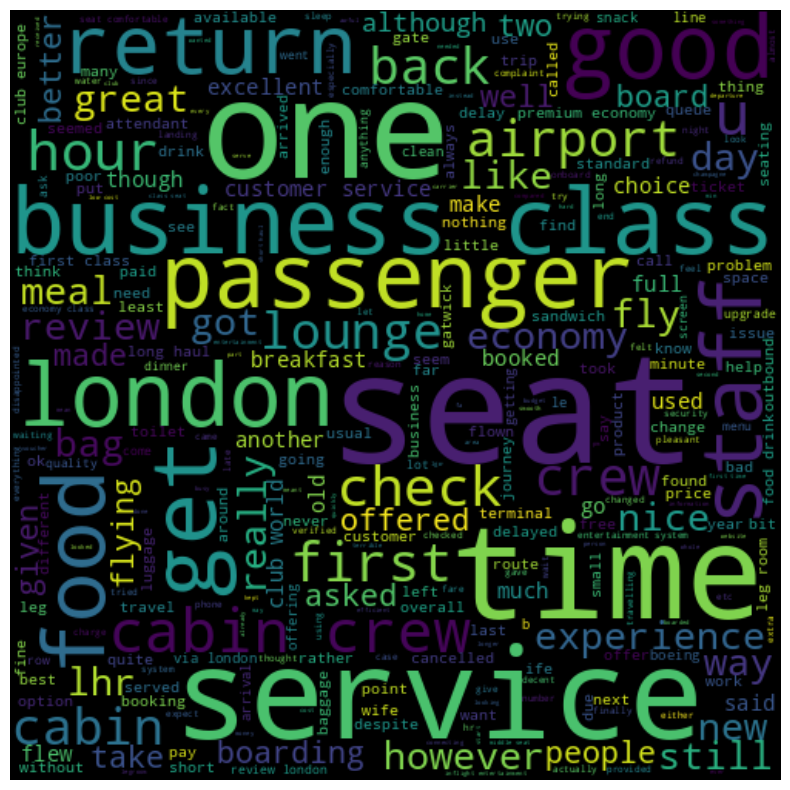

In [90]:
import nltk
from nltk.corpus import stopwords
reviews = " ".join(df.corpus)
plt.figure(figsize=(20,10))

stopwords = set(stopwords.words('english'))
stopwords.update(["ba","flight", "british","airway", "airline","plane", "told","also","passenger" \
                 "london", "heathrow", "aircraft", "could","even", "would"])

wordcloud = WordCloud(height=500,width=500,max_font_size=100, max_words=300, stopwords=stopwords).generate(reviews)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [91]:
words = reviews.split(" ")

In [92]:
stopwords = text.ENGLISH_STOP_WORDS.union(['flight', 'ba', "passenger","u", "london","airway","british","airline",\
                                           "heathrow","plane","lhr","review"])

new_words = [word for word in words if word not in stopwords]

nlp_words=FreqDist(new_words).most_common(20)

all_fdist = pd.Series(dict(nlp_words))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'seat'),
  Text(1, 0, 'service'),
  Text(2, 0, 'time'),
  Text(3, 0, 'food'),
  Text(4, 0, 'crew'),
  Text(5, 0, 'good'),
  Text(6, 0, 'cabin'),
  Text(7, 0, 'class'),
  Text(8, 0, 'hour'),
  Text(9, 0, 'staff'),
  Text(10, 0, 'business'),
  Text(11, 0, 'economy'),
  Text(12, 0, 'check'),
  Text(13, 0, 'drink'),
  Text(14, 0, 'meal'),
  Text(15, 0, 'lounge'),
  Text(16, 0, 'return'),
  Text(17, 0, 'club'),
  Text(18, 0, 'boarding'),
  Text(19, 0, 'experience')])

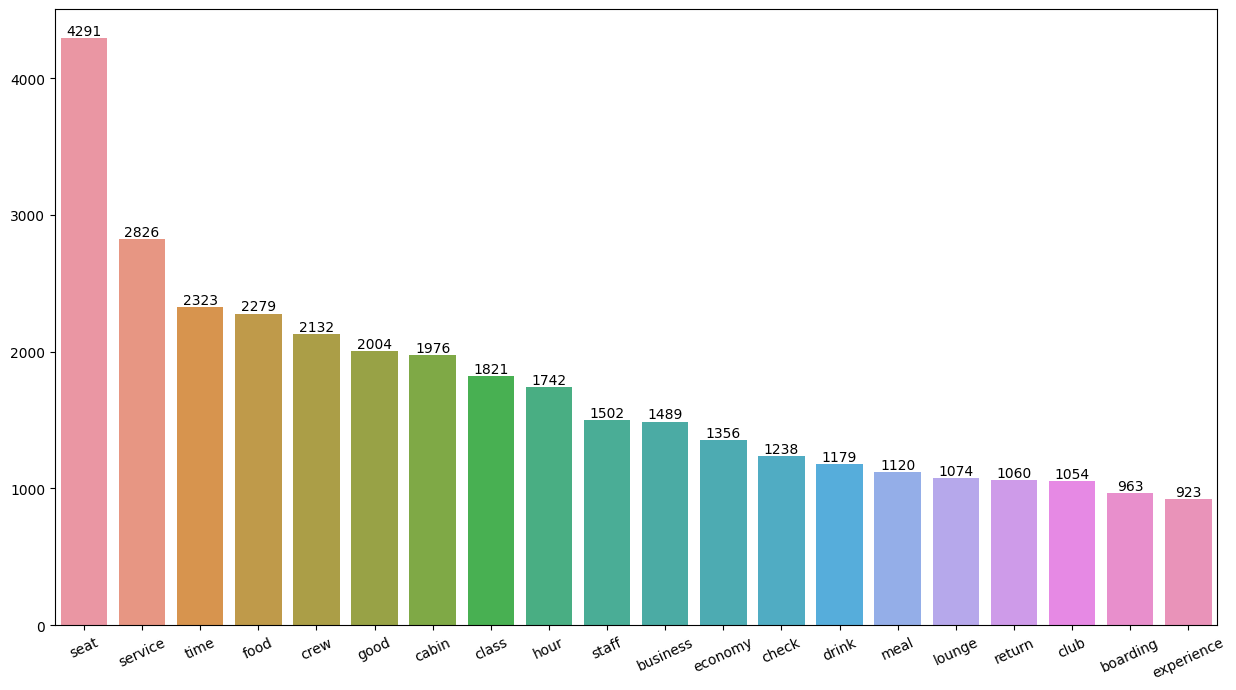

In [93]:
fig, ax = plt.subplots(figsize=(15,8))

all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
all_plot.bar_label(all_plot.containers[0])
plt.xticks(rotation=25)

This gives a glimpse of what customers are really talking about here. It can be seen that Seat is most talked about the airline followed by "Service" and "food" which are all very important to customers in terms of service. However, we still do not know is how they are expressing about each of this service. To bring some significane to these terms we will use ngram plots to see if they are bad or good in experience.

<Axes: >

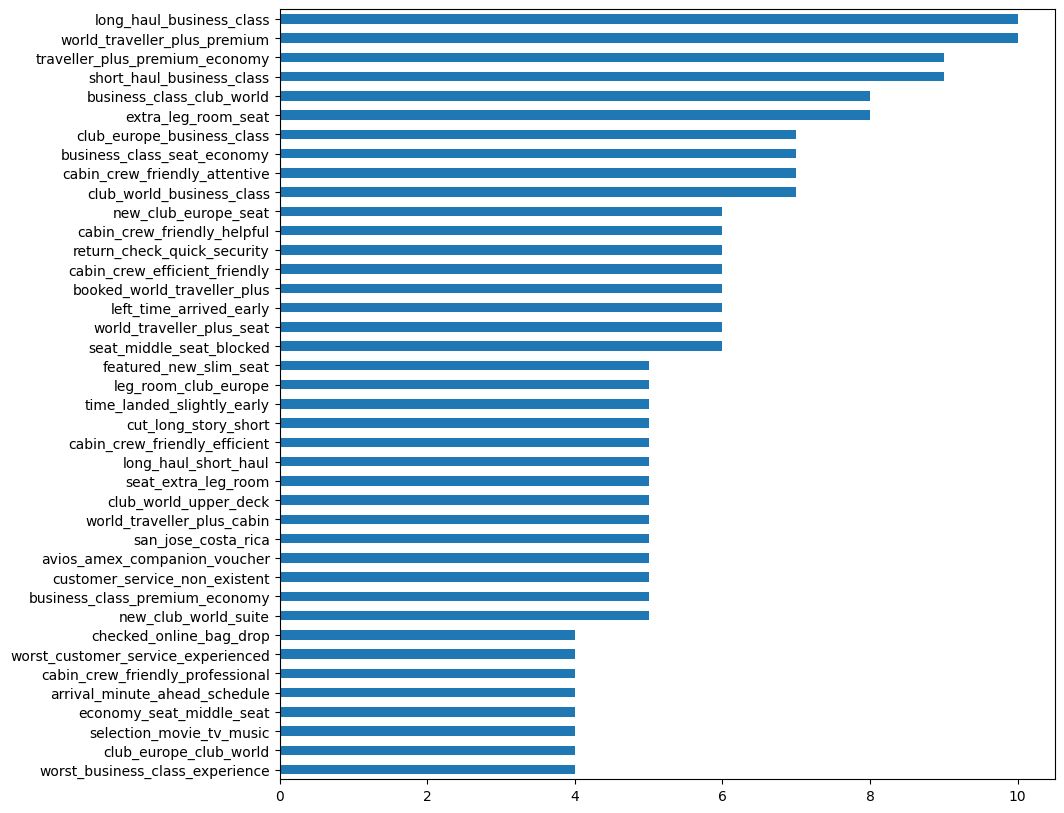

In [94]:
import nltk.collocations as collocations
from nltk import FreqDist, bigrams

reviews = " ".join(df.corpus)

words = reviews.split(" ")

new_words = [word for word in words if word not in stopwords]

def get_freq_dist(new_words,number_of_ngrams ):
    from nltk import ngrams
    
    ngrams = ngrams(new_words, number_of_ngrams)

    ngram_fd = FreqDist(ngrams).most_common(40)

    ngram_sorted = {k:v for k,v in sorted(ngram_fd, key=lambda item:item[1])}

    ngram_joined = {'_'.join(k):v for k,v in sorted(ngram_fd, key=lambda item:item[1])}

    ngram_freqdist = pd.Series(ngram_joined)
    plt.figure(figsize=(10,10))
    ax = ngram_freqdist.plot(kind="barh")
    
    return ax


get_freq_dist(new_words,4)

We can see that there are very common positive terms regarding cabin crew. For example, cabin_crew_friendly_helpful, cabin_crew_friendly_attentive, cabin_crew_friendly_efficient, etc. So certainly customers are providing good reviews about cabin crew staff of British Airways.

However, I tried finding the word frequencies which will give a better picture. So I grouped the reviews based on ratings. I assumed ratigs 1-3 as bad reviews, 4-6 as average/good experience and 7-10 as great experience.

<Axes: >

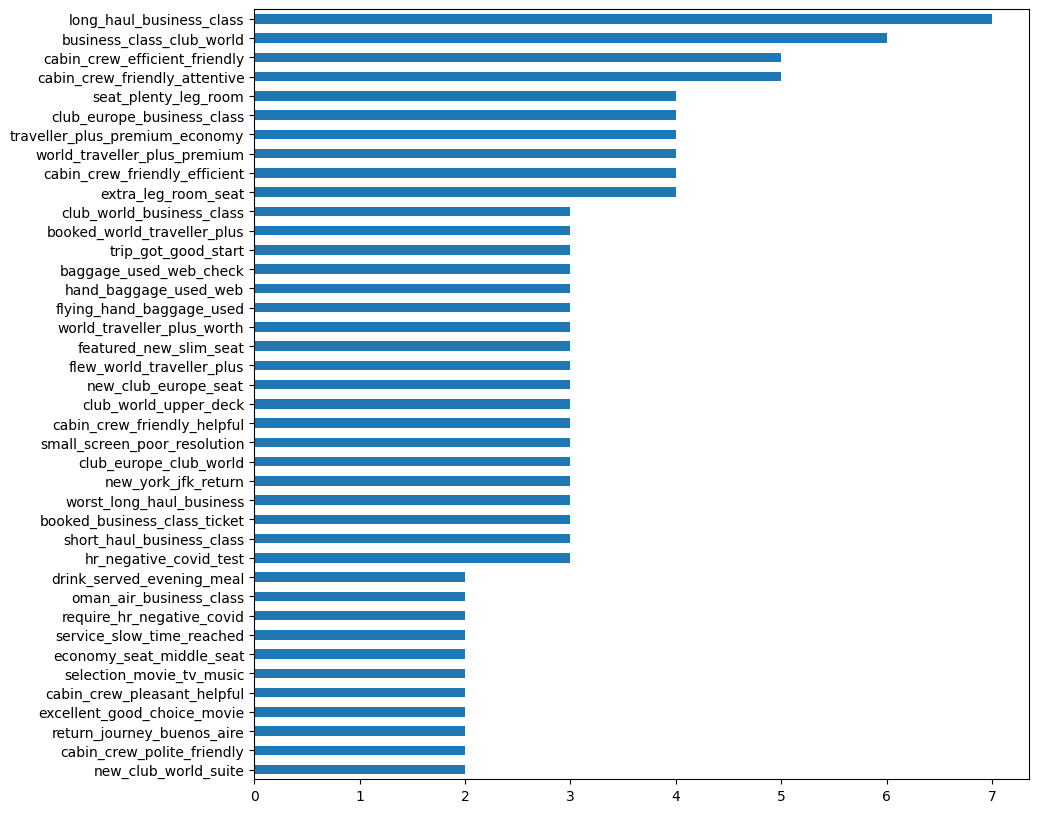

In [95]:
ratings_1_3 = df[df.stars.isin([1,2,3])]
ratings_4_6 = df[df.stars.isin([4,5,6])]
ratings_7_10 = df[df.stars.isin([7,8,9,10])]
reviews_1_3 = " ".join(ratings_1_3.corpus)
reviews_4_6 = " ".join(ratings_4_6.corpus)
reviews_7_10 = " ".join(ratings_7_10.corpus)

words_1_3 = reviews_1_3.split(" ")
words_4_6 = reviews_4_6.split(" ")
words_7_10 = reviews_7_10.split(" ")


new_words_7_10 = [word for word in words_7_10 if word not in stopwords]

get_freq_dist(new_words_7_10,4)

<Axes: >

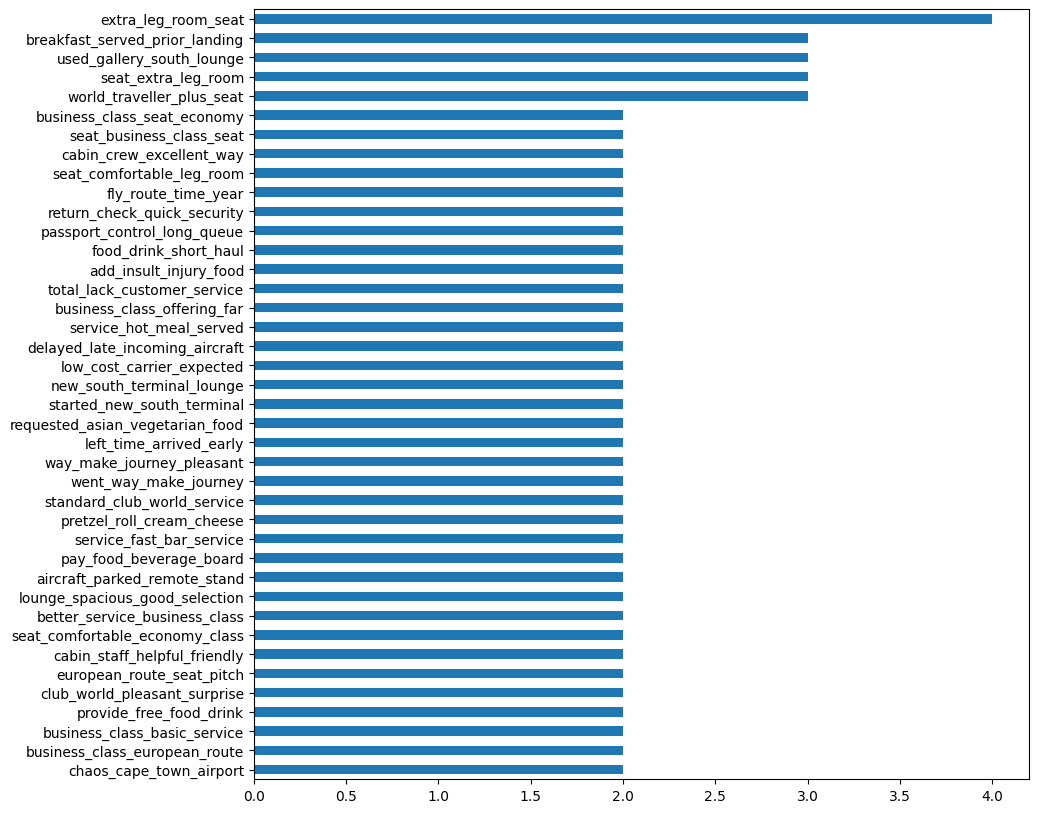

In [96]:
new_words = [word for word in words_4_6 if word not in stopwords]

get_freq_dist(new_words,4)

<Axes: >

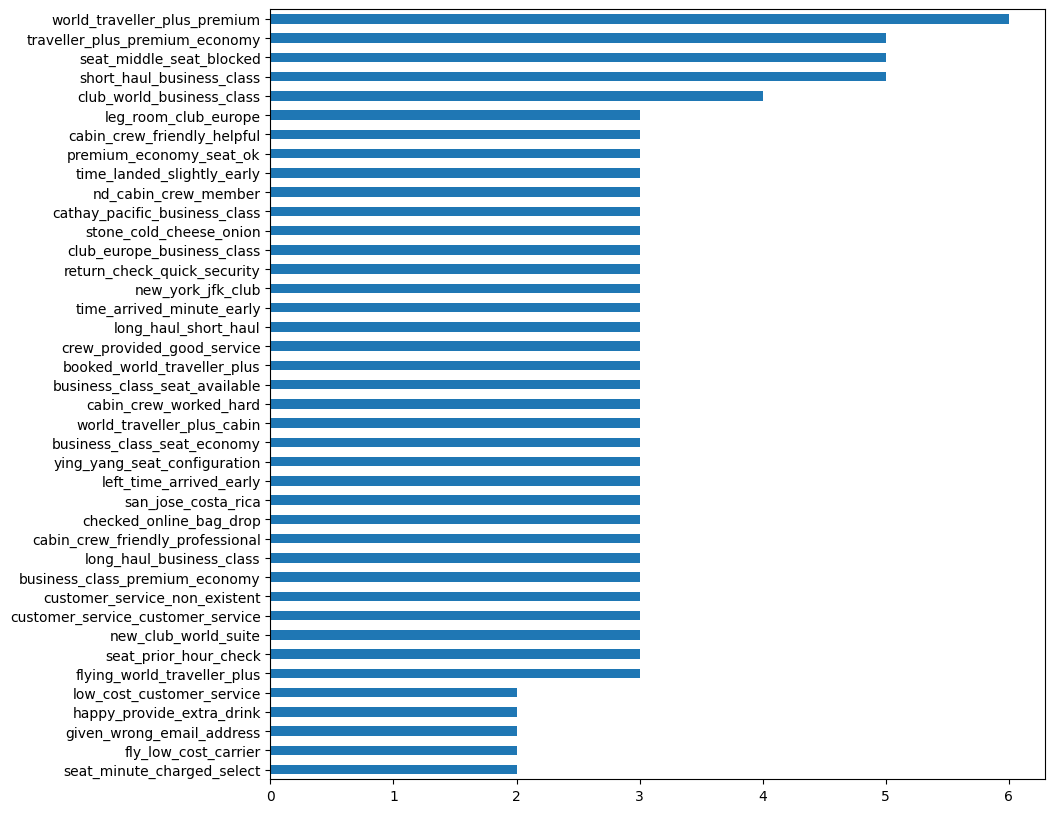

In [97]:
new_words = [word for word in words_1_3 if word not in stopwords]

get_freq_dist(new_words,4)

Next, I used textblob library to define if the text is negative or positive and upto what extent.

In [98]:
%%capture
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

df['polarity'] = 0

for i in range(len(df.corpus)):
    sent= TextBlob(df.corpus[i])
    polarity  = sent.sentiment.polarity
    subjectivity  = sent.sentiment.subjectivity
    df['polarity'][i] = polarity

In [99]:
print(f"{df[(df['polarity'] >-0.2) & (df['polarity'] <0.2)].shape[0]} number of reviews between -0.2 and 0.2 polarity score")

print(f"{df[(df['polarity'] >-0.1) & (df['polarity'] <0.1)].shape[0]} number of reviews between -0.1 and 0.1 polarity score")

2349 number of reviews between -0.2 and 0.2 polarity score
1354 number of reviews between -0.1 and 0.1 polarity score


In [100]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
nltk.download('vader_lexicon')
vds = SentimentIntensityAnalyzer()

df['label'] = 0
    
for i in range(len(df.corpus)):
    
    score = vds.polarity_scores(df.corpus[i])['compound']
    
    if score > 0.2:
        df['label'][i] = 1
        
    elif score < 0:
        df['label'][i] = -1
        
    else:
        df['label'][i] = 0

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
<ipython-input-100-e5b563f551ad>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-100-e5b563f551ad>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-100-e5b563f551ad>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [101]:
df.label.value_counts()

 1    2272
-1    1101
 0     120
Name: label, dtype: int64

# ***Topic Modelling with LDA***

We have already cleaned our reviews, however, for topic modeling we will also require word embeddings or (words matrix). For this purpose we will use count vectorizer method from sklearn library.

In [102]:
%%capture
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

tf = vect.fit_transform(df.corpus).toarray()
tf_feature_names = vect.get_feature_names_out()

In [103]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 8

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

model.fit(tf)

topic_dict = {}

for topic_idx, topic in enumerate(model.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    
df_topic =pd.DataFrame(topic_dict)

In [104]:
df_topic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights
0,flight,2415.7,seat,1041.5,flight,522.6,seat,523.2,flight,2499.9,lounge,446.1,flight,37.9,flight,787.6
1,ba,1644.1,class,1026.3,staff,207.5,meal,470.3,seat,1817.0,flight,208.8,airline,18.6,ba,732.9
2,hour,759.8,business,848.9,heathrow,204.6,flight,455.5,ba,1306.6,ba,205.9,staff,16.0,food,515.9
3,airway,698.1,economy,704.9,luggage,202.7,food,366.8,good,1158.7,class,183.5,passenger,15.5,club,502.4
4,british,687.6,ba,601.7,check,187.6,drink,308.6,crew,1034.8,check,179.9,senior,15.3,good,481.8
5,london,653.1,flight,483.1,london,186.9,crew,289.7,time,1030.0,good,159.8,haul,14.6,service,478.5
6,customer,651.0,british,434.3,hour,184.8,cabin,279.6,cabin,931.1,business,155.7,long,14.0,crew,444.0
7,service,634.3,service,429.0,delay,175.7,served,263.7,food,896.3,boarding,147.1,ba,13.4,cabin,440.8
8,would,592.9,airway,428.4,minute,166.1,hour,259.2,service,876.9,food,142.6,gatwick,12.2,lounge,440.6
9,told,583.3,airline,407.1,gate,138.4,service,232.6,london,670.8,time,135.5,cost,12.0,seat,440.4


# ***Topic modeling with NMF***

In [105]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2, init='random', random_state=0)
nmf.fit_transform(tf)

array([[0.05423853, 0.13790595],
       [0.00639913, 0.01827712],
       [0.00863665, 0.11612118],
       ...,
       [0.00721633, 0.06696382],
       [0.03247357, 0.18056938],
       [0.02769661, 0.        ]])

In [106]:
topic_dict = {}

for topic_idx, topic in enumerate(nmf.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    
df_topic =pd.DataFrame(topic_dict)

df_topic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights
0,seat,23.8,flight,20.7
1,ba,12.6,ba,7.0
2,class,10.2,hour,4.5
3,food,8.2,time,4.0
4,service,7.9,london,3.6
5,business,7.9,service,3.4
6,cabin,7.6,airway,3.3
7,good,7.1,british,3.3
8,crew,7.0,would,2.9
9,economy,6.3,staff,2.5


With NMF algorithm as well we see there are few words that are not conclusive like "seat". So we will remove such words from the list and try topic modeling again.

# ***Exploratory Data Analysis on Customer Bookings data for British Airways***

In [108]:
cwd = os.getcwd()


df = pd.read_csv(cwd + "/customer_booking.csv",  encoding="ISO-8859-1")

df.head()

df.shape

(50000, 14)

In [109]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

Sales Channel

In [111]:
per_internet = df.sales_channel.value_counts().values[0]  / df.sales_channel.count() *100
per_mobile = df.sales_channel.value_counts().values[1]  / df.sales_channel.count() *100

print(f"Number of bookings done through internet: {per_internet} %")
print(f"Number of bookings done through phone call: {per_mobile} %")

Number of bookings done through internet: 88.764 %
Number of bookings done through phone call: 11.236 %


Trip Type

In [112]:
per_round = df.trip_type.value_counts().values[0]/ df.trip_type.count() *100
per_oneway = df.trip_type.value_counts().values[1]/ df.trip_type.count() *100
per_circle = df.trip_type.value_counts().values[2]/ df.trip_type.count() *100

print(f"Percentage of round trips: {per_round} %")
print(f"Percentage of One way trips: {per_oneway} %")
print(f"Percentage of circle trips: {per_circle} %")

Percentage of round trips: 98.994 %
Percentage of One way trips: 0.774 %
Percentage of circle trips: 0.232 %


Purchase Lead


<Axes: xlabel='purchase_lead', ylabel='Count'>

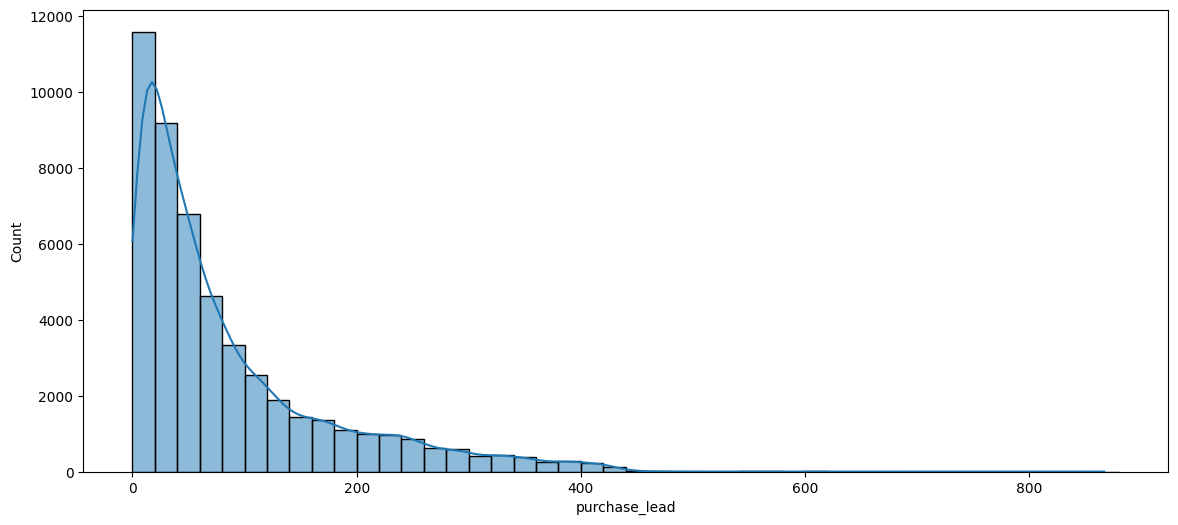

In [113]:
plt.figure(figsize=(14,6))
sns.histplot(data=df, x="purchase_lead", binwidth=20,kde=True)

There are few bookings that were done more than 2 years before the travel date and it seems very unlikely that book that in advance. However, it might also be because of the cancellation and rebooking in a period of 6 months for twice. Generally airline keep the tickets for rebooking within a year. But at this point we will consider them as outliers which will effect the results of predictive model in a huge way.

In [114]:
(df.purchase_lead >600).value_counts()

False    49992
True         8
Name: purchase_lead, dtype: int64

In [115]:
df[df.purchase_lead > 600]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
835,3,Internet,RoundTrip,641,46,6,Sun,AKLKUL,Malaysia,1,0,1,8.83,1
6148,1,Internet,RoundTrip,614,19,11,Wed,COKMEL,Australia,0,0,0,8.83,0
24119,1,Internet,RoundTrip,704,23,8,Tue,PNHSYD,Australia,0,0,0,8.58,0
38356,2,Internet,RoundTrip,633,5,10,Sat,HKTOOL,Australia,0,0,1,8.83,0
39417,1,Mobile,RoundTrip,625,5,15,Fri,ICNRGN,Myanmar (Burma),0,0,0,6.62,0
42916,1,Mobile,RoundTrip,605,6,18,Thu,BLRMEL,India,0,0,0,8.83,0
46716,2,Internet,RoundTrip,606,6,6,Fri,HKTTPE,United States,0,0,1,4.67,0
48259,3,Internet,RoundTrip,867,6,7,Mon,KIXMLE,Japan,0,0,1,7.00,1


Filtering the data to have only purchase lead days less than 600 days

In [116]:
df = df[df.purchase_lead <600 ]

### ***Length Of Stay***

<Axes: xlabel='length_of_stay', ylabel='Count'>

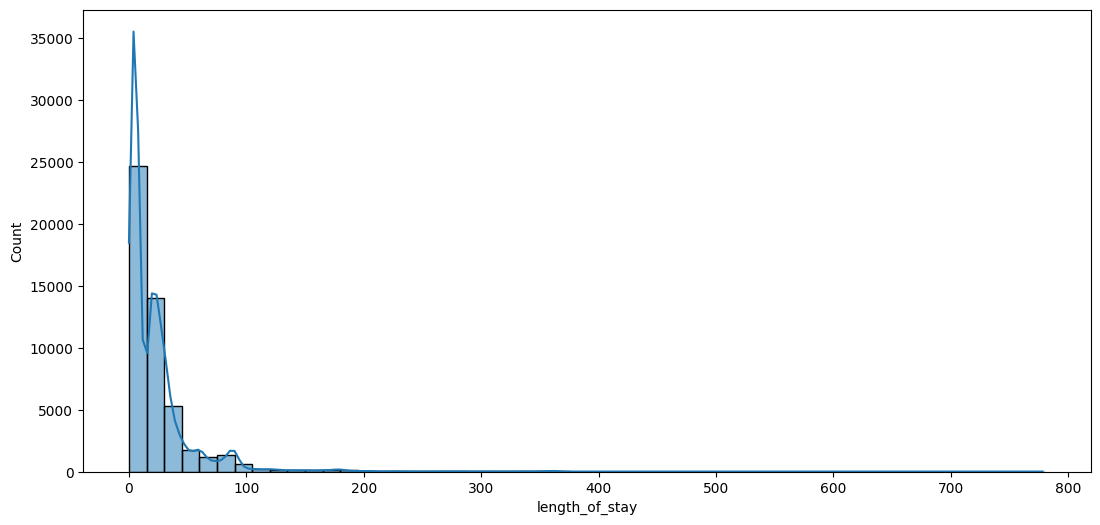

In [117]:
plt.figure(figsize=(13,6))
sns.histplot(data=df, x="length_of_stay", binwidth=15,kde=True)

Let's see how many entries do we have that exceeds length of stay more than 100 days.

In [118]:
(df.length_of_stay> 200).value_counts()

False    49713
True       279
Name: length_of_stay, dtype: int64

In [119]:
df[df.length_of_stay> 500].booking_complete.value_counts()

0    9
1    1
Name: booking_complete, dtype: int64

Filtering the data to have only length of stay days less than 500 days

In [120]:
df = df[df.purchase_lead <500 ]

# ***Flight Day***

Next, I mapped the flight day with a number of a week.

In [121]:
mapping = {
    "Mon" : 1,
    "Tue" : 2,
    "Wed" : 3,
    "Thu" : 4,
    "Fri" : 5,
    "Sat" : 6,
    "Sun" : 7
}

df.flight_day = df.flight_day.map(mapping)

<ipython-input-121-ca0f5a61a466>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [122]:
df.flight_day.value_counts()

1    8100
3    7671
2    7670
4    7423
5    6759
7    6550
6    5809
Name: flight_day, dtype: int64

# ***Booking Origin***

Text(0, 0.5, 'Number of bookings')

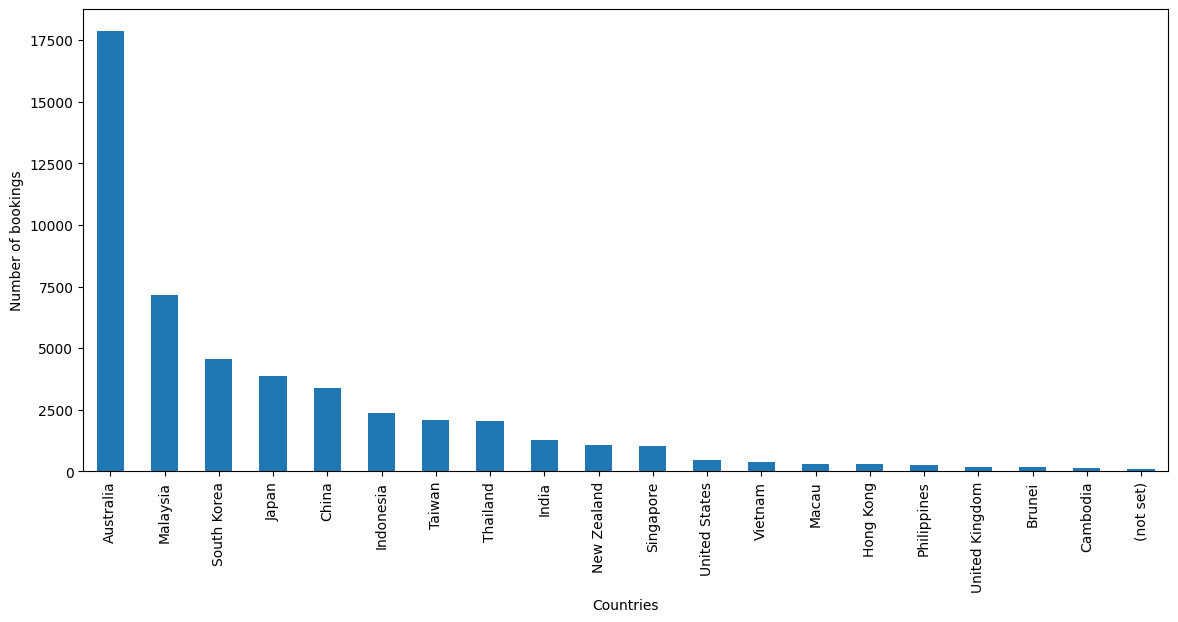

In [123]:
plt.figure(figsize=(14,6))
ax = df.booking_origin.value_counts()[:20].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of bookings")

Above chart shows travellers from which country had maximum booking applications.

Text(0, 0.5, 'Number of complete bookings')

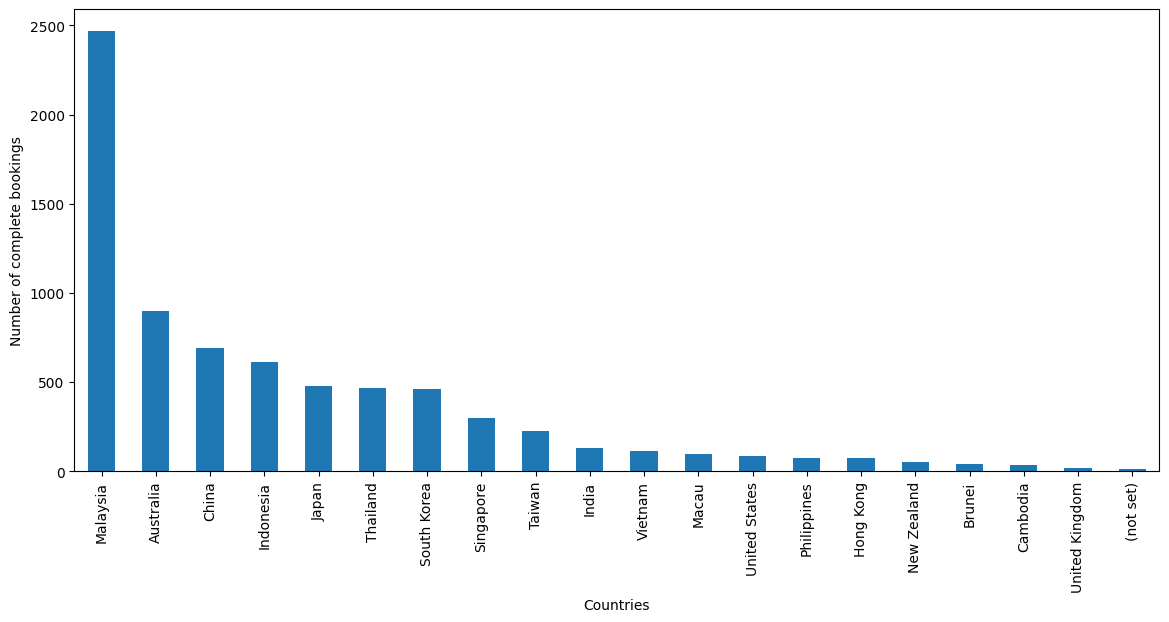

In [124]:
plt.figure(figsize=(14,6))
ax = df[df.booking_complete ==1].booking_origin.value_counts()[:20].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of complete bookings")

Above chart shows travellers from which country had their booking complete.

# ***Booking complete***

In [125]:
successful_booking_per = df.booking_complete.value_counts().values[0] / len(df) * 100
unsuccessful_booking_per = 100-successful_booking_per
print(f"Out of 50000 booking entries only {round(unsuccessful_booking_per,2)} % bookings were successfull or complete.")

Out of 50000 booking entries only 14.96 % bookings were successfull or complete.


Exporting the dataset to csv

In [126]:
df.to_csv(cwd + "/customer_booking_filtered.csv")

# ***Predictive Model***

In [127]:
plt.rcParams.update({'font.size': 14})

In [128]:
cwd = os.getcwd()

df = pd.read_csv(cwd + "/customer_booking_filtered.csv", index_col=0)

In [129]:
df = df.reset_index(drop=True)
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49978,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49979,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49980,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


Next, I one hot encode the categorical columns.

In [130]:
df_final = df

In [131]:
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(df[["sales_channel"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'Internet', 1:'Mobile'})
df_final = df_final.join(encoder_df)

encoder_df = pd.DataFrame(encoder.fit_transform(df[["trip_type"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'RoundTRip', 1:'OneWayTrip',2:'CircleTrip'})
df_final = df_final.join(encoder_df)

In [132]:
df_final.drop(['sales_channel', 'trip_type','booking_origin', 'route'], axis=1, inplace = True)

Storing the label for supervised learning

In [133]:
label = df['booking_complete']

In [134]:
df_final = df_final.drop('booking_complete', axis=1)
df_final

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip
0,2,262,19,7,6,1,0,0,5.52,1.0,0.0,0.0,0.0,1.0
1,1,112,20,3,6,0,0,0,5.52,1.0,0.0,0.0,0.0,1.0
2,2,243,22,17,3,1,1,0,5.52,1.0,0.0,0.0,0.0,1.0
3,1,96,31,4,6,0,0,1,5.52,1.0,0.0,0.0,0.0,1.0
4,2,68,22,15,3,1,0,1,5.52,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,2,27,6,9,6,1,0,1,5.62,1.0,0.0,0.0,0.0,1.0
49978,1,111,6,4,7,0,0,0,5.62,1.0,0.0,0.0,0.0,1.0
49979,1,24,6,22,6,0,0,1,5.62,1.0,0.0,0.0,0.0,1.0
49980,1,15,6,11,1,1,0,1,5.62,1.0,0.0,0.0,0.0,1.0


# ***Normalizaing the values***

In [135]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_df = scaler.fit_transform(df_final)

scaled_df = pd.DataFrame(scaled_df, columns = df_final.columns)

scaled_df['label']  = label

scaled_df

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip,label
0,0.400769,1.971093,-0.119401,-0.381588,1.096876,0.703587,-0.650054,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
1,-0.579424,0.302987,-0.089895,-1.120618,1.096876,-1.421288,-0.650054,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
2,0.400769,1.759799,-0.030885,1.465988,-0.408618,0.703587,1.538334,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
3,-0.579424,0.125056,0.234662,-0.935861,1.096876,-1.421288,-0.650054,1.158002,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
4,0.400769,-0.186323,-0.030885,1.096473,-0.408618,0.703587,-0.650054,1.158002,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,0.400769,-0.642272,-0.502969,-0.012073,1.096876,0.703587,-0.650054,1.158002,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
49978,-0.579424,0.291867,-0.502969,-0.935861,1.598707,-1.421288,-0.650054,-0.863557,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
49979,-0.579424,-0.675634,-0.502969,2.389776,1.096876,-1.421288,-0.650054,1.158002,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
49980,-0.579424,-0.775721,-0.502969,0.357443,-1.412280,0.703587,-0.650054,1.158002,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0


# ***Correlation matrix***

<Axes: >

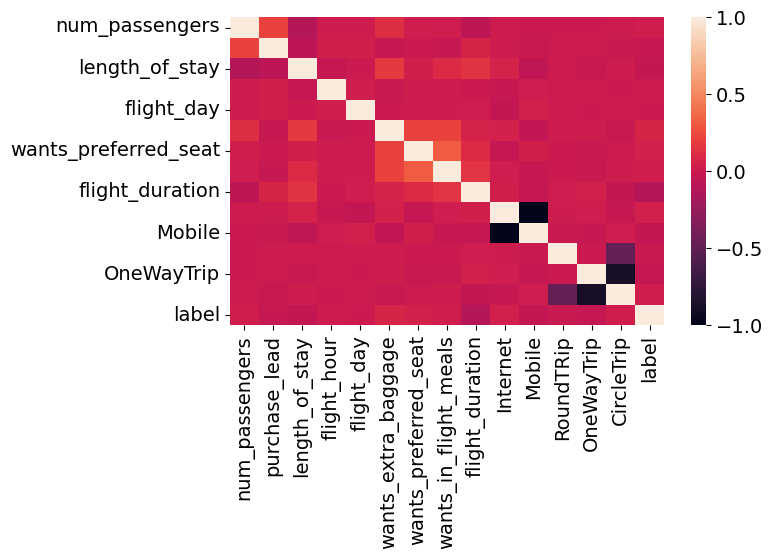

In [136]:
corr = scaled_df.corr()

plt.figure(figsize=(7,4))

sns.heatmap(corr)

Now let's split the dataset into train and test sets.

# ***Splitting Train and Test Data***

In [137]:
from sklearn.model_selection import train_test_split

X = scaled_df.iloc[:,:-1]
y = scaled_df['label']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.inspection import permutation_importance

from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV,  RepeatedStratifiedKFold

In [138]:
def model_fit_predict(model, X, y, X_predict):
    model.fit(X, y)
    return model.predict(X_predict)

def acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def pre_score(y_true, y_pred):
    return precision_score(y_true, y_pred)

def f_score(y_true, y_pred):
    return f1_score(y_true, y_pred)

# ***Random Forest Classifier***

Creating an instance of the classifier and fit the training data

In [139]:
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

*Checking Training accuracy*

In [140]:
y_pred_train = model_fit_predict(clf_rf, X_train, y_train, X_train)
set(y_pred_train)

f1 = round(f1_score(y_train, y_pred_train),2) 

acc = round(accuracy_score(y_train, y_pred_train),2) 

pre = round(precision_score(y_train, y_pred_train),2) 

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.93, 1.0 and 0.72 respectively


0.9341002876078529

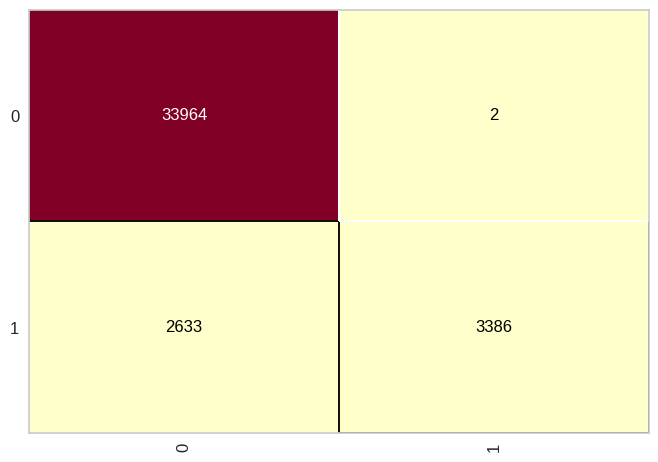

In [141]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_train, y_train)

# Checking Testing accuracy

Creating an instance of the classifier and fitting the training data

In [142]:
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

#f1 score for training data
f1 = round(f1_score(y_test, y_pred_test),2) 

#accuracy score for training data
acc = round(accuracy_score(y_test, y_pred_test),2) 

#precision score for training data
pre = round(precision_score(y_test, y_pred_test),2) 

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.86, 0.56 and 0.07 respectively


0.8554566369910973

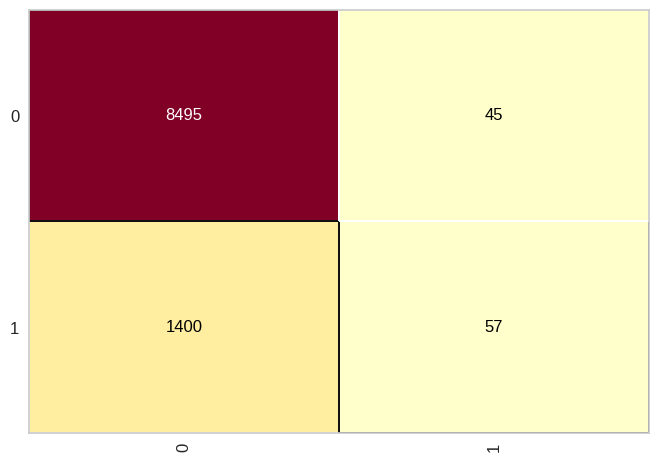

In [143]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_test, y_test)

Text(0.5, 0, 'Random Forest Feature Importance')

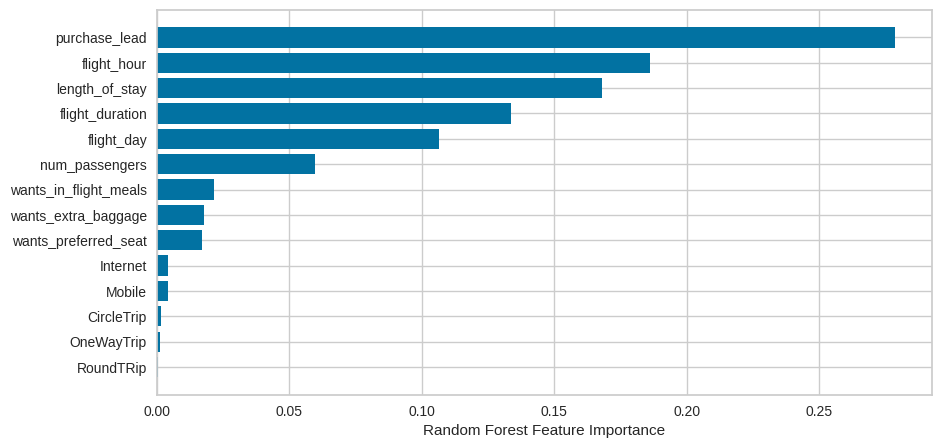

In [144]:
plt.figure(figsize=(10,5))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(scaled_df.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

One major problem behind getting low F1 score is imbalanced dataset. We have higher entries that are classified 0 than 1. We could reduce the number of entries that are classified 0 to be equal around the number of entries that are classified as 1.

# **Balancing the dataset**

In [145]:
scaled_df.label.value_counts()

0    42506
1     7476
Name: label, dtype: int64

Creating a dataframe having all labels 0 with 10000 samples

In [146]:
scaled_df_0 = scaled_df[scaled_df.label ==0].sample(n=8000)

Concatenating the two dataframee, one havng all labels 0 and other having all labels as 1

In [147]:
scaled_df_new = pd.concat([scaled_df[scaled_df.label==1], scaled_df_0], ignore_index=True)

Shuffling the dataframe rows

In [149]:
scaled_df_new = scaled_df_new.sample(frac = 1).reset_index(drop=True)

scaled_df_new

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip,label
0,-0.579424,-0.086237,-0.060390,-0.751103,-1.412280,0.703587,-0.650054,1.158002,0.870293,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
1,0.400769,-0.453220,1.267346,2.389776,-0.408618,0.703587,-0.650054,-0.863557,0.870293,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
2,-0.579424,-0.608910,-0.620990,-1.120618,1.598707,-1.421288,1.538334,-0.863557,-0.185282,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
3,0.400769,-0.342013,-0.001380,0.172685,-1.412280,0.703587,-0.650054,-0.863557,0.195526,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
4,0.400769,0.669971,0.824767,-0.935861,-0.408618,0.703587,1.538334,1.158002,1.037314,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15471,-0.579424,-0.775721,0.057631,0.357443,-0.910449,-1.421288,-0.650054,-0.863557,1.037314,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
15472,-0.579424,1.092557,-0.030885,-1.674891,-1.412280,0.703587,-0.650054,-0.863557,0.195526,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
15473,-0.579424,1.837644,0.116641,0.357443,0.093214,0.703587,-0.650054,1.158002,0.870293,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
15474,-0.579424,1.348333,-0.119401,0.542200,0.093214,0.703587,1.538334,-0.863557,0.870293,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0


In [150]:
X = scaled_df_new.iloc[:,:-1]
y = scaled_df_new['label']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

In [151]:
clf_rf = RandomForestClassifier(n_estimators=50,max_depth =50 , min_samples_split=5,random_state=0)

In [152]:
y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

f1 = round(f1_score(y_test, y_pred_test),2) 

acc = round(accuracy_score(y_test, y_pred_test),2) 

pre = round(precision_score(y_test, y_pred_test),2) 

recall = round(recall_score(y_test, y_pred_test),2)

specificity = round(recall_score(y_test, y_pred_test, pos_label=0),2)

print(f"Accuracy, precision, recall and f1-score for training data are {acc}, {pre}, {recall}, {specificity} and {f1} respectively") 

Accuracy, precision, recall and f1-score for training data are 0.61, 0.62, 0.58, 0.65 and 0.6 respectively


0.6146640826873385

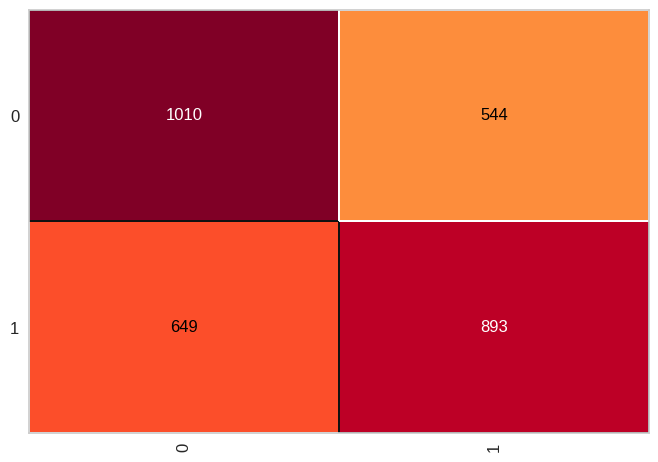

In [153]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_test, y_test)

Text(0.5, 0, 'Random Forest Feature Importance')

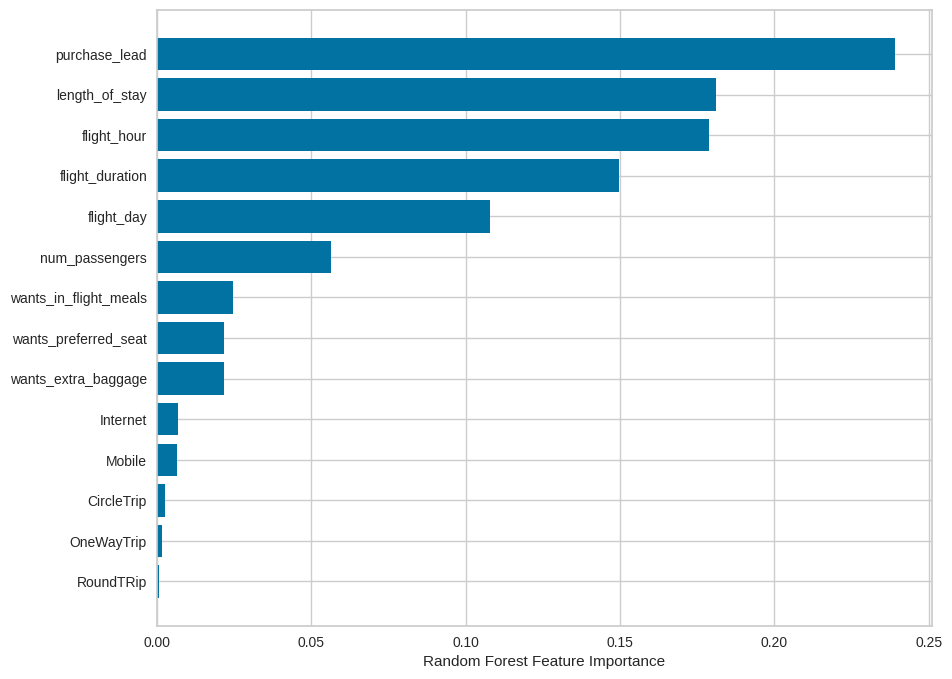

In [154]:
plt.figure(figsize=(10,8))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(scaled_df.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")